In [62]:
import numpy as np
import torch
from scipy import signal
import torchvision
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
class Normalize:
    def __call__(self, img):
        img = img.astype(np.float32) / 255
        return img


class PIL2numpy:
    def __call__(self, img):
        return np.array(img)


class ToTensor:
    def __call__(self, arr):
        arr = torch.from_numpy(arr)
        return arr


class OneHot:
    def __init__(self, num_classes=10):
        self.num_classes = num_classes

    def __call__(self, target):
        one_hot_target = np.zeros(self.num_classes, dtype=np.float32)
        one_hot_target[target] = 1
        return one_hot_target

In [ ]:
class Conv2D(Layer):
    def __init__(self, input_shape, kernel_size, depth, transposed=False):
        super().__init__()
        self.transposed = transposed
        input_depth, input_height, input_width = input_shape
        self.depth = depth
        self.input_shape = input_shape
        self.input_depth = input_depth

        if self.transposed is False:
            self.output_shape = (depth, input_height - kernel_size + 1, input_width - kernel_size + 1)
        else:
            self.output_shape = (depth, input_height + kernel_size - 1, input_width + kernel_size - 1)

        self.kernels_shape = (depth, input_depth, kernel_size, kernel_size)
        self.kernels = np.ones(self.kernels_shape)
        self.biases = np.ones(self.output_shape)

    def __call__(self, input):
        self.input = input
        self.output = np.copy(self.biases)

        if self.transposed is False:
            for i in range(self.depth):
                for j in range(self.input_depth):
                    self.output[i] += signal.correlate2d(self.input[j], self.kernels[i, j], "valid")
        else:
            for i in range(self.depth):
                for j in range(self.input_depth):
                    self.output[i] += signal.convolve2d(self.input[j], self.kernels[i, j], "full")

        return self.output

    def backward(self, output_gradient, learning_rate):
        kernels_gradient = np.zeros(self.kernels_shape)
        input_gradient = np.zeros(self.input_shape)

        if self.transposed is False:
            for i in range(self.depth):
                for j in range(self.input_depth):
                    kernels_gradient[i, j] = signal.correlate2d(self.input[j], output_gradient[i], "valid")
                    input_gradient[j] += signal.convolve2d(output_gradient[i], self.kernels[i, j], "full")
        else:
            for i in range(self.depth):
                for j in range(self.input_depth):
                    kernels_gradient[i, j] = signal.correlate2d(self.input[j], output_gradient[i], "valid")
                    input_gradient[j] += signal.correlate2d(output_gradient[i], self.kernels[i, j], "valid")

        self.kernels -= learning_rate * kernels_gradient
        self.biases -= learning_rate * output_gradient
        return input_gradient


class MeanSquaredErrorLoss:
    def __init__(self):
        self.predict = None
        self.target = None

    def __call__(self, target, predict):
        self.target = target
        self.predict = predict
        return np.mean((self.predict - self.target)**2) / 2

    def backward(self):
        return (self.predict - self.target) / len(self.target)


class ReLU:
    def __call__(self, x):
        x = np.array(x, dtype=np.float32)
        y = np.where(x > 0, x, 0)
        self.y = y
        return y

    def backward(self, dEdy):
        dydx = np.where(self.y <= 0, self.y, 1)
        dEdx = dEdy * dydx
        return dEdx

In [69]:
class Autoencoder:
    def __init__(self):
        self.layers = []
        self.layers.append(Conv2D((1, 28, 28), 3, 1))
        self.layers.append(ReLU())
        self.layers.append(Conv2D((1, 26, 26), 3, 1, transposed=True))
        self.layers.append(ReLU())

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def backward(self, x, learning_rate=0.01):
        for layer in self.layers[::-1]:
            if isinstance(layer, Conv2D):
                x = layer.backward(x, learning_rate)
            else:
                x = layer.backward(x)


def get_class_dict(train=True):
    transforms = torchvision.transforms.Compose([
        PIL2numpy(),
        Normalize(),
    ])
    target_transform = torchvision.transforms.Compose([
        OneHot()
    ])

    dataset = torchvision.datasets.MNIST(
        # dataset = torchvision.datasets.FashionMNIST(
        root='./data',
        train=train,
        download=True,
        transform=transforms,
        target_transform=target_transform
    )

    class_dict = {}

    for _, target in dataset:
    
        target = np.argmax(target).item()
        if target not in class_dict:
            class_dict[target] = []
        class_dict[target].append(_)

    return class_dict


def train_loop(dataset, model, criterion, learning_rate):
    losses = []  
    for idx, image in enumerate(dataset):
        pred = model([image])
        loss = criterion(image, pred)
        losses.append(loss)  
        x = criterion.backward()
        model.backward(x, learning_rate)
    
    return losses

In [92]:
num_epochs = 1
learning_rate = 0.3
train_class_dict = get_class_dict(train=True)
models = [Autoencoder() for _ in range(len(train_class_dict.keys()))]

criterion = MeanSquaredErrorLoss()

correct_guesses = [0] * len(train_class_dict.keys())
incorrect_guesses = [0] * len(train_class_dict.keys())

all_losses = []
for model, cls in zip(models, sorted(train_class_dict.keys())):
    for epoch in range(num_epochs):
        all_losses.append(train_loop(train_class_dict[cls], model, criterion, learning_rate))

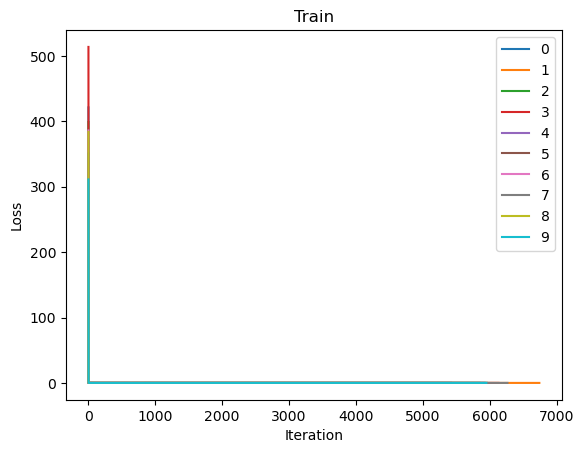

In [93]:
for cls in range(len(all_losses)):
    plt.plot(all_losses[cls], label=f'{cls}')

plt.title('Train')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [94]:
test_class_dict = get_class_dict(train=False)

for true_cls in sorted(test_class_dict.keys()):
    for image in test_class_dict[true_cls]:
        loss = []
        for idx, model in enumerate(models):
            pred = model([image])
            loss.append(criterion(image, pred).sum())
        predicted_cls = np.argmin(loss)
        if predicted_cls == true_cls:
            correct_guesses[true_cls] += 1
        else:
            incorrect_guesses[true_cls] += 1

for cls, (correct, incorrect) in enumerate(zip(correct_guesses, incorrect_guesses)):
    total = correct + incorrect
    print(f"{cls}:\t{correct} / {total} \t{correct / total * 100}%")

total_correct = sum(correct_guesses)
total_images = sum(correct_guesses) + sum(incorrect_guesses)
total_accuracy = total_correct / total_images * 100

print(f"\nTotal Accuracy: {total_correct} / {total_images} \t{total_accuracy:.2f}%")

0:	668 / 980 	68.16326530612244%
1:	1112 / 1135 	97.97356828193833%
2:	456 / 1032 	44.18604651162791%
3:	595 / 1010 	58.91089108910891%
4:	839 / 982 	85.43788187372708%
5:	502 / 892 	56.27802690582959%
6:	741 / 958 	77.34864300626305%
7:	761 / 1028 	74.0272373540856%
8:	561 / 974 	57.59753593429158%
9:	661 / 1009 	65.51040634291377%

Total Accuracy: 6896 / 10000 	68.96%
